# XGBoostの可視化

In [ ]:
# # Colabでバージョンを変更するとき、コメントアウトして実行してください
# !pip install numpy==1.22.4
# !pip install matplotlib==3.7.1
# !pip install graphviz==0.20.1
# !pip install scikit-learn==1.2.2
# !pip install xgboost==1.7.5

In [1]:
# ライブラリのインポート
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
# バージョンの確認
import matplotlib
import sklearn
print(np.__version__)
print(matplotlib.__version__)
print(sklearn.__version__)
print(xgb.__version__)

1.22.4
3.7.1
1.2.2
1.7.5


In [3]:
# 特徴量と目的変数の設定
X_train = np.array([[10], [20], [30], [40], [50], [60], [70], [80]])
y_train = np.array([6, 5, 7, 1, 2, 1, 6, 4])

In [4]:
# ハイパーパラメータの設定

xgb_train = xgb.DMatrix(X_train, label=y_train)

params = {
    'objective': 'reg:squarederror', # 損失関数
    'eval_metric': 'rmse', # 評価指標
    'max_depth': 2, # 深さの最大値
    'learning_rate': 0.8, # 学習率
    'base_score': 4, # 予測の初期値
    'min_split_loss': 0, # 枝刈り
    'reg_lambda': 0, # L2正則化
    'reg_alpha': 0, # L1正則化
    'seed': 0, # 乱数
}

In [5]:
# XGBoostの学習
model = xgb.train(params,
                  xgb_train,
                  evals=[(xgb_train, 'train')],
                  num_boost_round=2)

[0]	train-rmse:0.76158
[1]	train-rmse:0.61774


In [6]:
# XGBoostの予測
model.predict(xgb.DMatrix(X_train))

array([5.84     , 5.3599997, 6.56     , 1.4399999, 1.4399999, 1.4399999,
       4.96     , 4.96     ], dtype=float32)

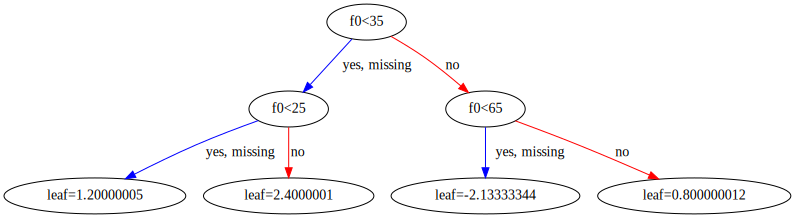

In [7]:
# 1本目の木の可視化
xgb.to_graphviz(model, num_trees=0)

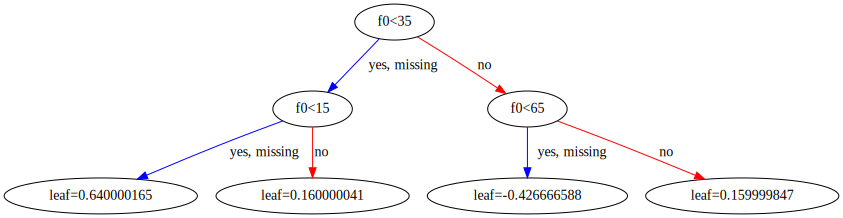

In [8]:
# 2本目の木の可視化
xgb.to_graphviz(model, num_trees=1)

# 予測値の検証

In [9]:
# 二乗誤差の重み
def weight(res, lam=0):
    if len(res)==0:
        return 0
    return sum(res)/(len(res)+lam)

In [10]:
# 二乗誤差の類似度
def similarity(res, lam=0):
    if len(res)==0:
        return 0
    return  sum(res)**2/(len(res)+lam)

In [11]:
# 分割点ごとの左葉類似度＋右葉類似度の計算
def split(X_train, residual):
  # プロット用のリスト
  index_plt = []
  similarity_plt = []
  # L2正則化
  lam = 0
  # 2次元配列を1次元配列
  X_train = X_train.flatten()
  # 分割点ごとの重みと類似度を計算
  for i in range(1, len(X_train)):
      X_left = np.array(X_train[:i])
      X_right = np.array(X_train[i:])
      res_left = np.array(residual[:i])
      res_right = np.array(residual[i:])
      # 分割点のインデックス      
      print('*****')
      print('index', i)
      index_plt.append(i)
      # 分割後の配列
      print('X_left:', X_left)
      print('X_right:', X_right)
      print('res_left:', res_left)
      print('res_right:', res_right)
      # 重み
      print('res_weight_left:', weight(res_left, lam))
      print('res_weight_right:', weight(res_right, lam))
      # 類似度
      print('similarity_left:', similarity(res_left, lam))
      print('similarity_right:', similarity(res_right, lam))      
      # 左葉類似度＋右葉類似度の合計
      print('similarity_total:', similarity(res_left, lam) + similarity(res_right, lam))
      similarity_plt.append(similarity(res_left, lam) + similarity(res_right, lam))     
      print('')

  # 1次元配列→2次元配列
  index_plt = np.array(index_plt)
  X_plt = index_plt[:, np.newaxis]
  # 分割点ごとの類似度を可視化
  plt.figure(figsize=(10, 4)) #プロットのサイズ指定  
  plt.plot(X_plt, similarity_plt)
  plt.xlabel('index')
  plt.ylabel('Similarity Score')
  plt.title('Similarity Score vs Split Point index')
  plt.grid()
  plt.show()

In [12]:
# 初期値の計算
pred0 = np.mean(y_train)
pred0

4.0

In [13]:
# 残差1=正解値-初期値
residual1 = y_train - pred0
residual1

array([ 2.,  1.,  3., -3., -2., -3.,  2.,  0.])

*****
index 1
X_left: [10]
X_right: [20 30 40 50 60 70 80]
res_left: [2.]
res_right: [ 1.  3. -3. -2. -3.  2.  0.]
res_weight_left: 2.0
res_weight_right: -0.2857142857142857
similarity_left: 4.0
similarity_right: 0.5714285714285714
similarity_total: 4.571428571428571

*****
index 2
X_left: [10 20]
X_right: [30 40 50 60 70 80]
res_left: [2. 1.]
res_right: [ 3. -3. -2. -3.  2.  0.]
res_weight_left: 1.5
res_weight_right: -0.5
similarity_left: 4.5
similarity_right: 1.5
similarity_total: 6.0

*****
index 3
X_left: [10 20 30]
X_right: [40 50 60 70 80]
res_left: [2. 1. 3.]
res_right: [-3. -2. -3.  2.  0.]
res_weight_left: 2.0
res_weight_right: -1.2
similarity_left: 12.0
similarity_right: 7.2
similarity_total: 19.2

*****
index 4
X_left: [10 20 30 40]
X_right: [50 60 70 80]
res_left: [ 2.  1.  3. -3.]
res_right: [-2. -3.  2.  0.]
res_weight_left: 0.75
res_weight_right: -0.75
similarity_left: 2.25
similarity_right: 2.25
similarity_total: 4.5

*****
index 5
X_left: [10 20 30 40 50]
X_right: [60 

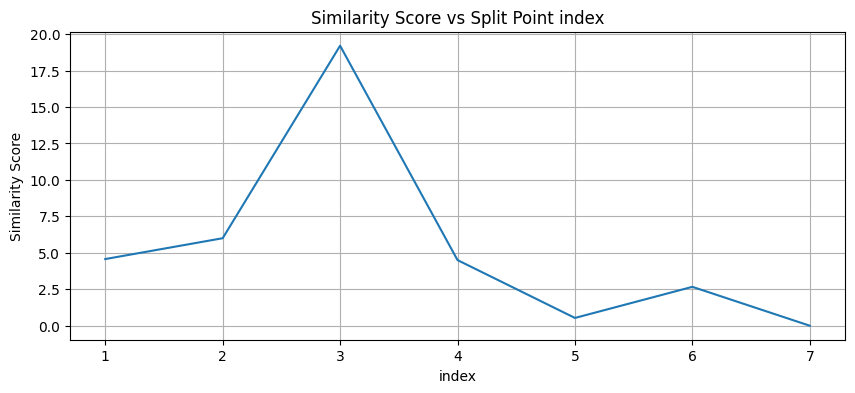

In [14]:
# 残差1の深さ1の分割点
X_train = np.array([[10], [20], [30], [40], [50], [60], [70], [80]])
split(X_train, residual1)

*****
index 1
X_left: [10]
X_right: [20 30]
res_left: [2]
res_right: [1 3]
res_weight_left: 2.0
res_weight_right: 2.0
similarity_left: 4.0
similarity_right: 8.0
similarity_total: 12.0

*****
index 2
X_left: [10 20]
X_right: [30]
res_left: [2 1]
res_right: [3]
res_weight_left: 1.5
res_weight_right: 3.0
similarity_left: 4.5
similarity_right: 9.0
similarity_total: 13.5



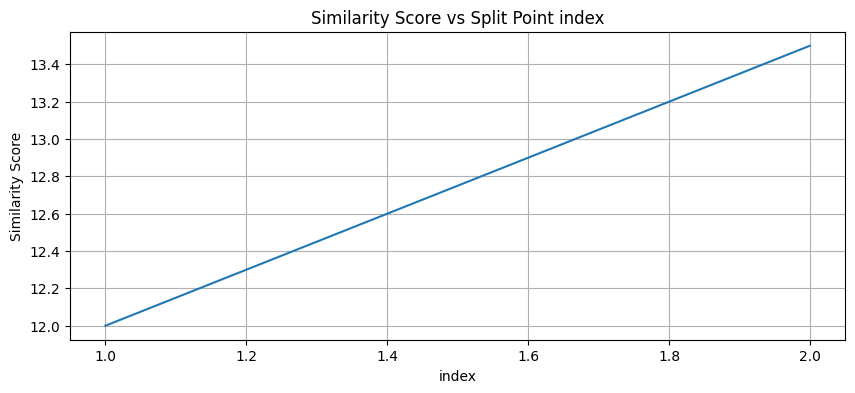

In [15]:
# 左葉：残差1の深さ2の分割点
X_train1_L = np.array([[10], [20], [30]])
residual1_L = np.array([2, 1, 3])
split(X_train1_L, residual1_L)

*****
index 1
X_left: [40]
X_right: [50 60 70 80]
res_left: [-3]
res_right: [-2 -3  2  0]
res_weight_left: -3.0
res_weight_right: -0.75
similarity_left: 9.0
similarity_right: 2.25
similarity_total: 11.25

*****
index 2
X_left: [40 50]
X_right: [60 70 80]
res_left: [-3 -2]
res_right: [-3  2  0]
res_weight_left: -2.5
res_weight_right: -0.3333333333333333
similarity_left: 12.5
similarity_right: 0.3333333333333333
similarity_total: 12.833333333333334

*****
index 3
X_left: [40 50 60]
X_right: [70 80]
res_left: [-3 -2 -3]
res_right: [2 0]
res_weight_left: -2.6666666666666665
res_weight_right: 1.0
similarity_left: 21.333333333333332
similarity_right: 2.0
similarity_total: 23.333333333333332

*****
index 4
X_left: [40 50 60 70]
X_right: [80]
res_left: [-3 -2 -3  2]
res_right: [0]
res_weight_left: -1.5
res_weight_right: 0.0
similarity_left: 9.0
similarity_right: 0.0
similarity_total: 9.0



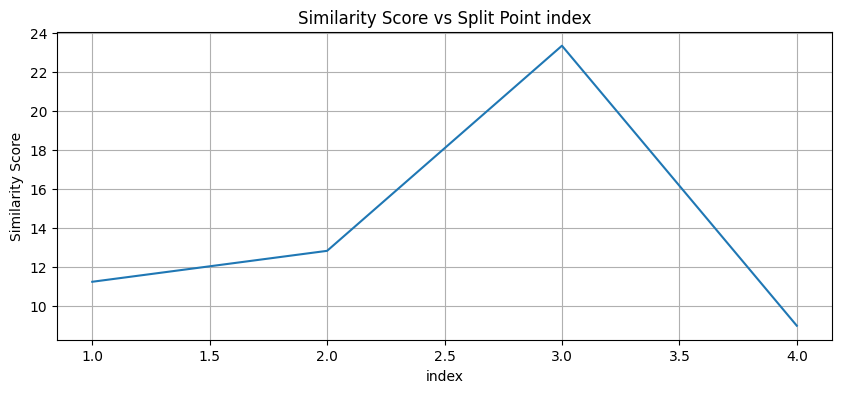

In [16]:
# 右葉：残差1の深さ2の分割点
X_train1_R = np.array([[40], [50], [60], [70], [80]])
residual1_R = np.array([-3, -2, -3,  2,  0])
split(X_train1_R, residual1_R)

In [17]:
# 学習率×1回ブースティングした重み
weight1 = np.array([1.5, 1.5, 3, -2.6666666666666665, -2.6666666666666665, -2.6666666666666665, 1, 1])
0.8 * weight1

array([ 1.2       ,  1.2       ,  2.4       , -2.13333333, -2.13333333,
       -2.13333333,  0.8       ,  0.8       ])

In [18]:
# 予測値1=初期値+学習率×重み1
pred1 = pred0 + 0.8 * weight1
pred1

array([5.2       , 5.2       , 6.4       , 1.86666667, 1.86666667,
       1.86666667, 4.8       , 4.8       ])

In [19]:
# 予測値1のRMSE
print('RMSE train: %.5f' % (mean_squared_error(y_train, pred1) ** 0.5))

RMSE train: 0.76158


In [20]:
# 残差2=正解値-予測値1
residual2 = y_train - pred1
residual2

array([ 0.8       , -0.2       ,  0.6       , -0.86666667,  0.13333333,
       -0.86666667,  1.2       , -0.8       ])

*****
index 1
X_left: [10]
X_right: [20 30 40 50 60 70 80]
res_left: [0.8]
res_right: [-0.2         0.6        -0.86666667  0.13333333 -0.86666667  1.2
 -0.8       ]
res_weight_left: 0.7999999999999998
res_weight_right: -0.11428571428571432
similarity_left: 0.6399999999999997
similarity_right: 0.0914285714285715
similarity_total: 0.7314285714285712

*****
index 2
X_left: [10 20]
X_right: [30 40 50 60 70 80]
res_left: [ 0.8 -0.2]
res_right: [ 0.6        -0.86666667  0.13333333 -0.86666667  1.2        -0.8       ]
res_weight_left: 0.2999999999999998
res_weight_right: -0.10000000000000002
similarity_left: 0.1799999999999998
similarity_right: 0.06000000000000002
similarity_total: 0.23999999999999982

*****
index 3
X_left: [10 20 30]
X_right: [40 50 60 70 80]
res_left: [ 0.8 -0.2  0.6]
res_right: [-0.86666667  0.13333333 -0.86666667  1.2        -0.8       ]
res_weight_left: 0.39999999999999974
res_weight_right: -0.23999999999999994
similarity_left: 0.4799999999999995
similarity_right: 0.287

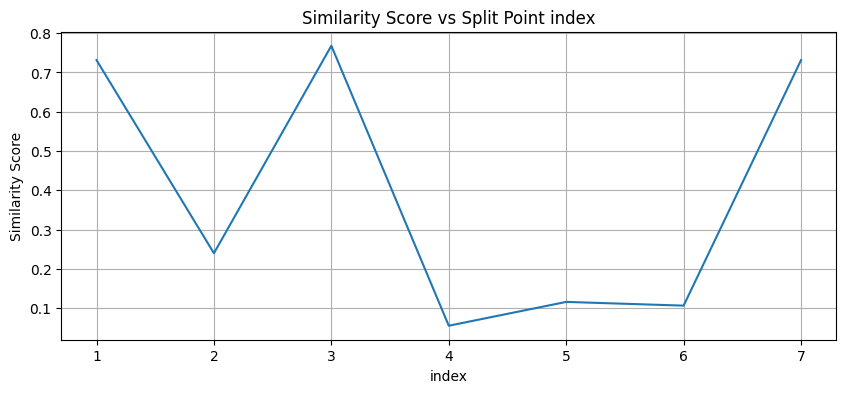

In [21]:
# 残差2の深さ1の分割点
X_train = np.array([[10], [20], [30], [40], [50], [60], [70], [80]])
split(X_train, residual2)

*****
index 1
X_left: [10]
X_right: [20 30]
res_left: [0.8]
res_right: [-0.2  0.6]
res_weight_left: 0.8
res_weight_right: 0.19999999999999998
similarity_left: 0.6400000000000001
similarity_right: 0.07999999999999999
similarity_total: 0.7200000000000001

*****
index 2
X_left: [10 20]
X_right: [30]
res_left: [ 0.8 -0.2]
res_right: [0.6]
res_weight_left: 0.30000000000000004
res_weight_right: 0.6
similarity_left: 0.18000000000000005
similarity_right: 0.36
similarity_total: 0.54



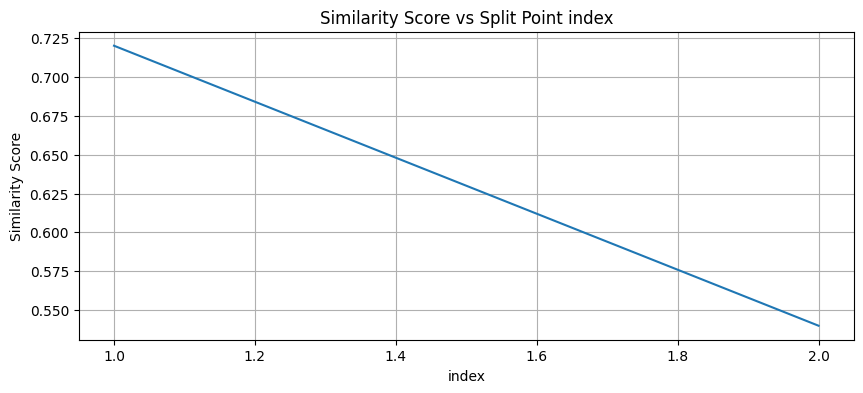

In [22]:
# 左葉：残差2の深さ2の分割点
X_train2_L = np.array([[10], [20], [30]])
residual2_L = np.array([ 0.8, -0.2, 0.6])
split(X_train2_L, residual2_L)

*****
index 1
X_left: [40]
X_right: [50 60 70 80]
res_left: [-0.86666667]
res_right: [ 0.13333333 -0.86666667  1.2        -0.8       ]
res_weight_left: -0.86666667
res_weight_right: -0.08333333500000001
similarity_left: 0.7511111168888889
similarity_right: 0.027777778888888906
similarity_total: 0.7788888957777778

*****
index 2
X_left: [40 50]
X_right: [60 70 80]
res_left: [-0.86666667  0.13333333]
res_right: [-0.86666667  1.2        -0.8       ]
res_weight_left: -0.36666667
res_weight_right: -0.15555555666666668
similarity_left: 0.26888889377777775
similarity_right: 0.07259259362962965
similarity_total: 0.3414814874074074

*****
index 3
X_left: [40 50 60]
X_right: [70 80]
res_left: [-0.86666667  0.13333333 -0.86666667]
res_right: [ 1.2 -0.8]
res_weight_left: -0.5333333366666667
res_weight_right: 0.19999999999999996
similarity_left: 0.853333344
similarity_right: 0.07999999999999996
similarity_total: 0.933333344

*****
index 4
X_left: [40 50 60 70]
X_right: [80]
res_left: [-0.86666667  

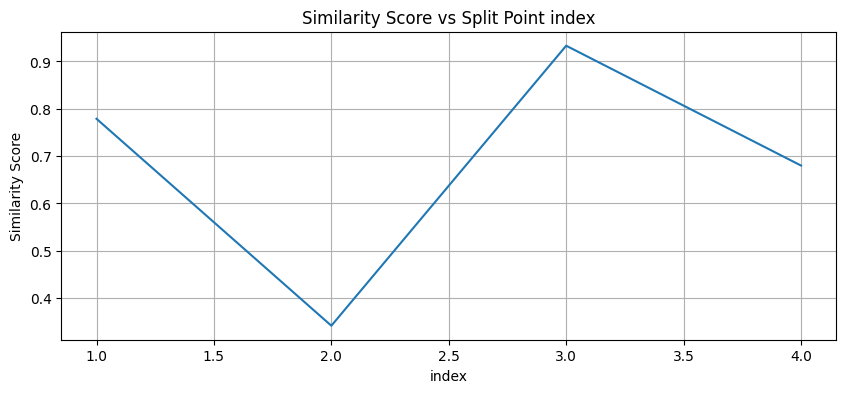

In [23]:
# 右葉：残差2の深さ2の分割点
X_train2_R = np.array([[40], [50], [60], [70], [80]])
residual2_R  = np.array([-0.86666667, 0.13333333, -0.86666667, 1.2, -0.8])
split(X_train2_R, residual2_R)

In [24]:
# 学習率×2回ブースティングした重み
weight2 = np.array([0.8, 0.2, 0.2, -0.5333333366666667, -0.5333333366666667, -0.5333333366666667, 0.19999999999999996, 0.19999999999999996])
0.8 * weight2

array([ 0.64      ,  0.16      ,  0.16      , -0.42666667, -0.42666667,
       -0.42666667,  0.16      ,  0.16      ])

In [25]:
# 予測値2=予測値1+学習率×重み2
pred2 = pred1 + 0.8 * weight2
pred2

array([5.84, 5.36, 6.56, 1.44, 1.44, 1.44, 4.96, 4.96])

In [26]:
# 予測値2のRMSE
print('RMSE train: %.5f' % (mean_squared_error(y_train, pred2) ** 0.5))

RMSE train: 0.61774


# 枝刈り

In [27]:
# ハイパーパラメータの設定
params2 = {
    'objective': 'reg:squarederror', # 損失関数
    'eval_metric': 'rmse', # 評価指標
    'max_depth': 2, # 深さの最大値
    'learning_rate': 0.8, # 学習率
    'base_score': 4, # 初期値
    'min_split_loss': 1.51, # 枝刈り
    'reg_lambda': 0, # L2正則化
    'reg_alpha': 0, # L1正則化
    'seed': 0
    }

In [28]:
# XGBoostの学習
model2 = xgb.train(params2,
                  xgb_train,
                  evals=[(xgb_train, 'train')],
                  num_boost_round=1)

[0]	train-rmse:0.87178


In [29]:
# XGBoostの予測
model2.predict(xgb.DMatrix(X_train))

array([5.6      , 5.6      , 5.6      , 1.8666666, 1.8666666, 1.8666666,
       4.8      , 4.8      ], dtype=float32)

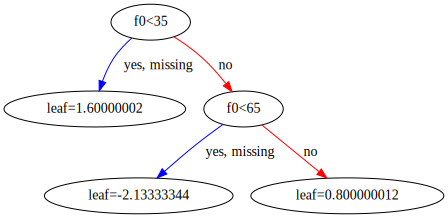

In [30]:
# 1本目の木の可視化
xgb.to_graphviz(model2, num_trees=0)